https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/

https://stackoverflow.com/questions/61524717/pytorch-how-to-find-accuracy-for-multi-label-classification

In [1]:
path = "./data/regionsnorth/"

import csv
from collections import namedtuple

filepath_to_label = {}
filepaths = []

with open('./data/regionsnorth/file2.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for idx, row in enumerate(reader):
        if idx != 0:
            filepath = row[4]
            label = row[6]
            filepath_to_label[filepath] = label
            filepaths.append(filepath)

import numpy as np
            
np_filepaths = np.array(sorted(filepaths))

In [2]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_idx, test_idx = next(sss.split(np_filepaths))

train_np_filepaths = [np_filepaths[ind] for ind in train_idx]
test_np_filepaths = [np_filepaths[ind] for ind in test_idx]

In [3]:
# Data set
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import random
import torchvision

np.random.seed(2021)
random.seed(2021)
torch.manual_seed(2021)

labels = sorted(["nothing", "unvisible", "sowing", "harvesting"])
label_to_idx = {cls_name: i for i, cls_name in enumerate(labels)}

idx_to_label = {value:key for key, value in label_to_idx.items()}

class FieldsDataset(Dataset):
    def __init__(self, file_paths, filepath_to_label, transform):
        self.transform = transform
        self.file_paths = file_paths
        self.filepath_to_label = filepath_to_label
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]

        frame = Image.open(path + file_path).convert('RGB') # Converting to RGB to make sure the tensor of 3 layers

        seed = np.random.randint(1e9)
        
        random.seed(seed)
        np.random.seed(seed)
        
        frame = self.transform(frame)

        return frame, label_to_idx[filepath_to_label[file_path]]

In [4]:
# Transforms

import torchvision.transforms as transforms

h, w =224, 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transformer = transforms.Compose([
        transforms.Resize((h,w)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomAffine(degrees=0,
        #                        translate=(0.1,0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
])

# Create dataset
train_ds = FieldsDataset(file_paths=train_np_filepaths, filepath_to_label=filepath_to_label, transform=train_transformer)
print(len(train_ds))

# Test data trasnform
test_transformer = transforms.Compose([
    transforms.Resize((h,w)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_ds = FieldsDataset(file_paths=test_np_filepaths, filepath_to_label=filepath_to_label, transform=test_transformer)
print(len(test_ds))

6807
757


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

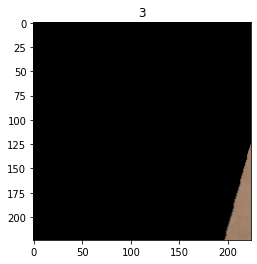

In [6]:
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
img, label = next(iter(train_ds))

# Make a grid from batch
out = torchvision.utils.make_grid(img)

imshow(out, title=label)

In [7]:
# def collate_fn_rnn(batch):
#     imgs_batch, label_batch = list(zip(*batch))
#     imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
#     label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
#     imgs_tensor = torch.stack(imgs_batch)
#     labels_tensor = torch.stack(label_batch)
#     return imgs_tensor,labels_tensor

batch_size = 16 # NOTE HERE

train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size= 2*batch_size, shuffle=False)

dataloaders = {}
dataloaders['train'] = train_dl
dataloaders['val'] = test_dl

dataset_sizes = {}
dataset_sizes['train'] = len(train_ds)
dataset_sizes['val'] = len(test_ds)

In [8]:
# Get a batch of training data
inputs, label_idxes = next(iter(dataloaders['train']))

print(inputs)
print(label_idxes)

#Make a grid from batch
#out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[idx_to_label[x] for x in label_idxes])

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ...,  0.6221,  0.6563,  0.6734],
          [-2.1179, -2.1179, -2.1179,  ...,  0.6392,  0.6392,  0.6563],
          [-2.1179, -2.1179, -2.1179,  ...,  0.6392,  0.6049,  0.6049]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ...,  0.2402,  0.2752,  0.3102],
          [-2.0357, -2.0357, -2.0357,  ...,  0.2927,  0.2927,  0.2927],
          [-2.0357, -2.0357, -2.0357,  ...,  0.2927,  0.2577,  0.2577]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [9]:
from tqdm import notebook

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in notebook.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                torch.save(model.state_dict(), "./models/weights_classification.pt")
                print("Copied best model weights!")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, label_idxs) in enumerate(dataloaders['val']):
            print(inputs)
            inputs = inputs.to(device)
            label_idxs = label_idxs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            outputs11 = torch.sigmoid(outputs)
#             outputs11[outputs11 >= 0.5] = 1
            outputs11[outputs11 < 0.5] = 0
            print(idx_to_label)
            print(outputs11)
            #outputs[outputs >= 0.5] = 1

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('pr: {} | tr: {}'.format(labels[preds[j]], labels[label_idxs[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(labels))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
import time
import copy

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25) #25

Epoch 0/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.3902 Acc: 0.8776


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3194 Acc: 0.8771
Copied best model weights!

Epoch 1/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.2552 Acc: 0.9011


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3088 Acc: 0.8824
Copied best model weights!

Epoch 2/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.1444 Acc: 0.9433


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3262 Acc: 0.8811

Epoch 3/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0776 Acc: 0.9733


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3068 Acc: 0.9049
Copied best model weights!

Epoch 4/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0628 Acc: 0.9780


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3242 Acc: 0.9009

Epoch 5/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0401 Acc: 0.9850


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3350 Acc: 0.8983

Epoch 6/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0375 Acc: 0.9872


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3472 Acc: 0.9049

Epoch 7/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0290 Acc: 0.9916


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3011 Acc: 0.9115
Copied best model weights!

Epoch 8/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0152 Acc: 0.9971


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.2989 Acc: 0.9168
Copied best model weights!

Epoch 9/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0113 Acc: 0.9982


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3017 Acc: 0.9194
Copied best model weights!

Epoch 10/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0092 Acc: 0.9991


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3045 Acc: 0.9207
Copied best model weights!

Epoch 11/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0076 Acc: 0.9994


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3077 Acc: 0.9221
Copied best model weights!

Epoch 12/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0064 Acc: 0.9999


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3111 Acc: 0.9221

Epoch 13/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0055 Acc: 0.9999


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3144 Acc: 0.9221

Epoch 14/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0047 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3145 Acc: 0.9221

Epoch 15/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0047 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3147 Acc: 0.9221

Epoch 16/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0046 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3150 Acc: 0.9234
Copied best model weights!

Epoch 17/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0045 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3152 Acc: 0.9234

Epoch 18/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0045 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3154 Acc: 0.9234

Epoch 19/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0044 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3157 Acc: 0.9234

Epoch 20/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0044 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3159 Acc: 0.9234

Epoch 21/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0043 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3159 Acc: 0.9234

Epoch 22/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0043 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3160 Acc: 0.9234

Epoch 23/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0043 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3160 Acc: 0.9234

Epoch 24/24
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.0043 Acc: 1.0000


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3160 Acc: 0.9234

Training complete in 24m 27s
Best val Acc: 0.923382


tensor([[[[ 0.6392,  0.5707,  0.5193,  ...,  0.4679,  0.4851,  0.5193],
          [ 0.6392,  0.5707,  0.5193,  ...,  0.4679,  0.4851,  0.5193],
          [ 0.6049,  0.5364,  0.5022,  ...,  0.4679,  0.4851,  0.5022],
          ...,
          [ 0.3652,  0.3823,  0.3823,  ...,  0.3994,  0.4166,  0.4508],
          [ 0.3652,  0.3652,  0.3652,  ...,  0.4166,  0.4337,  0.4508],
          [ 0.3652,  0.3652,  0.3652,  ...,  0.4166,  0.4337,  0.4508]],

         [[ 0.4153,  0.3627,  0.3102,  ...,  0.2927,  0.3102,  0.3452],
          [ 0.4153,  0.3627,  0.3102,  ...,  0.2927,  0.3102,  0.3452],
          [ 0.3803,  0.3277,  0.2927,  ...,  0.2927,  0.3102,  0.3277],
          ...,
          [ 0.1877,  0.2052,  0.2052,  ...,  0.2227,  0.2402,  0.2927],
          [ 0.1877,  0.1877,  0.1877,  ...,  0.2402,  0.2577,  0.2927],
          [ 0.1877,  0.1877,  0.1877,  ...,  0.2402,  0.2577,  0.2927]],

         [[ 0.2173,  0.1651,  0.1128,  ...,  0.1302,  0.1476,  0.1651],
          [ 0.2173,  0.1651,  

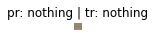

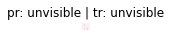

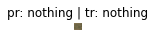

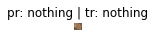

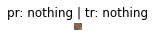

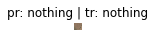

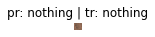

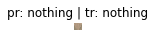

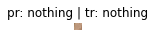

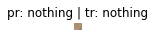

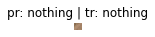

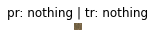

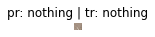

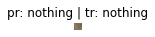

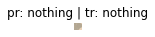

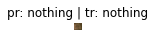

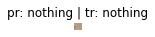

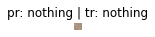

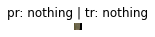

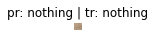

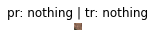

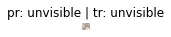

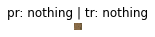

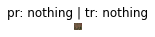

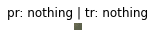

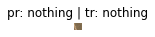

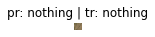

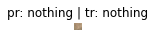

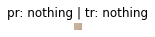

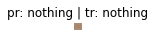

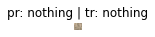

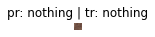

tensor([[[[ 0.5536,  0.5536,  0.5878,  ...,  0.3138,  0.3652,  0.4337],
          [ 0.5364,  0.5364,  0.5707,  ...,  0.2624,  0.3138,  0.3823],
          [ 0.5707,  0.5707,  0.6049,  ...,  0.2111,  0.2282,  0.2967],
          ...,
          [ 0.5878,  0.4508,  0.4166,  ...,  0.3994,  0.3994,  0.3994],
          [ 0.6906,  0.5364,  0.5022,  ...,  0.3652,  0.3652,  0.3823],
          [ 0.8618,  0.7419,  0.6392,  ...,  0.2967,  0.2967,  0.3309]],

         [[ 0.4153,  0.4328,  0.4678,  ...,  0.1877,  0.2052,  0.2752],
          [ 0.3978,  0.3978,  0.4328,  ...,  0.1352,  0.1527,  0.2227],
          [ 0.4328,  0.4328,  0.4678,  ...,  0.0826,  0.0826,  0.1527],
          ...,
          [ 0.4503,  0.3102,  0.2752,  ...,  0.1352,  0.1527,  0.1527],
          [ 0.5553,  0.3978,  0.3627,  ...,  0.1176,  0.1352,  0.1352],
          [ 0.7304,  0.6078,  0.5028,  ...,  0.0651,  0.0826,  0.1001]],

         [[ 0.0605,  0.0779,  0.1128,  ..., -0.1312, -0.0964, -0.0267],
          [ 0.0431,  0.0431,  

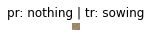

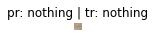

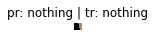

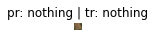

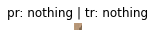

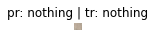

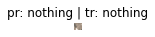

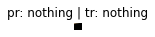

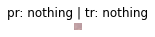

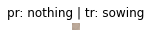

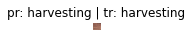

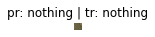

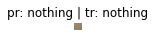

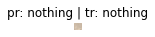

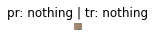

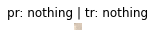

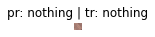

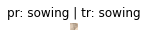

In [18]:
visualize_model(model_ft, 50)

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(labels))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1) #25

Epoch 0/0
----------


  0%|          | 0/426 [00:00<?, ?it/s]

train Loss: 0.4236 Acc: 0.8769


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.3662 Acc: 0.8719

Training complete in 0m 36s
Best val Acc: 0.871863
